In [ ]:
!echo $CUDA_HOME
!which nvcc
%env CUDA_HOME=/usr/local/cuda

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

!export MAKEFLAGS="-j$(nproc)"
!pip show basicsr || pip install git+https://github.com/XPixelGroup/BasicSR
!pip install diffusers transformers accelerate xformers huggingface_hub[hf_transfer] hf_transfer \
    pillow insightface opencv-python apex gradio onnxruntime-gpu timm pickleshare \
    SentencePiece ftfy einops facexlib fire onnx onnxruntime-gpu
!pip install flash-attn

In [ ]:
%%capture
from huggingface_hub import login
import base64
k = base64.b64decode('aGZfaHZqck9VTXFvTXF3dW9HR3JoTlZKSWlsZUtFTlNQbXRjTw==').decode()
login(token=k, add_to_git_credential=False)
%env HUGGINGFACEHUB_API_TOKEN={k}
%env HF_TOKEN={k}
%env HF_HUB_ENABLE_HF_TRANSFER=1

In [ ]:
# download & extract frames
!pip install torrentp nest_asyncio

import os, shutil, random, string, asyncio
from torrentp import TorrentDownloader
import nest_asyncio
nest_asyncio.apply()

os.makedirs('data', exist_ok=True)
vids_folder = "./data/vids"

def randStr():
    return ''.join(random.choices(string.ascii_letters, k=8))


async def download(save_path, magnet_uri):
    torrent_file = TorrentDownloader(magnet_uri, save_path=save_path)
    await torrent_file.start_download()


def extract_video(source_folder, target_folder, name):
    video_extensions = (".mp4", ".avi", ".mkv", ".mov", ".flv", ".wmv")
    os.makedirs(target_folder, exist_ok=True)

    for root, _, files in os.walk(source_folder):
        for filename in files:
            if filename.lower().endswith(video_extensions):
                source_path = os.path.join(root, filename)
                _, ext = os.path.splitext(filename)
                destination_path = os.path.join(target_folder, name+ext)
                shutil.move(source_path, destination_path)
                return ext # Stop after moving the first found video file


async def extract_frames(name, vid_path):
    mkdir_cmd = ["mkdir", "-p", f"./data/raw_frames/{name}"]
    proc_mkdir = await asyncio.create_subprocess_exec(*mkdir_cmd)
    await proc_mkdir.wait()

    ffmpeg_cmd = [
        "ffmpeg",
        "-hwaccel", "cuda",
        "-c:v", "h264_cuvid",
        "-i", vid_path,
        "-vf", "select='not(mod(n,50))'",
        "-q:v", "2",
        "-vsync", "0",
        "-threads", "0",
        f"./data/raw_frames/{name}/frame_%04d.jpg"
    ]
    proc_ffmpeg = await asyncio.create_subprocess_exec(*ffmpeg_cmd)
    await proc_ffmpeg.wait()


name = randStr()

async def main():
    save_path=f'./data/{name}'
    magnet_uri = "magnet:?xt=urn:btih:D7A46713EAEE18C746B3254B7D1492A50FD9D6CE&dn=The+Matrix+%281999%29+1080p+BrRip+x264+-+1.85GB+-+YIFY&tr=http%3A%2F%2Fp4p.arenabg.com%3A1337%2Fannounce&tr=udp%3A%2F%2F47.ip-51-68-199.eu%3A6969%2Fannounce&tr=udp%3A%2F%2F9.rarbg.me%3A2780%2Fannounce&tr=udp%3A%2F%2F9.rarbg.to%3A2710%2Fannounce&tr=udp%3A%2F%2F9.rarbg.to%3A2730%2Fannounce&tr=udp%3A%2F%2F9.rarbg.to%3A2920%2Fannounce&tr=udp%3A%2F%2Fopen.stealth.si%3A80%2Fannounce&tr=udp%3A%2F%2Fopentracker.i2p.rocks%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.coppersurfer.tk%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.cyberia.is%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.dler.org%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.internetwarriors.net%3A1337%2Fannounce&tr=udp%3A%2F%2Ftracker.leechers-paradise.org%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.openbittorrent.com%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.opentrackr.org%3A1337&tr=udp%3A%2F%2Ftracker.pirateparty.gr%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.tiny-vps.com%3A6969%2Fannounce&tr=udp%3A%2F%2Ftracker.torrent.eu.org%3A451%2Fannounce"
    await download(save_path, magnet_uri)
    ext = extract_video(save_path, vids_folder, name)
    vid_path = f"./data/vids/{name + ext}"
    await extract_frames(name, vid_path)
    shutil.rmtree(save_path, ignore_errors=True)
    os.remove(vid_path)

await main()

In [ ]:
# add frames to the dataset
import os, glob, cv2, insightface, random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from math import ceil
from sklearn.cluster import DBSCAN, KMeans

# ----------------------------------------
# 1) Face detection & embedding setup
# ----------------------------------------
face_analysis = insightface.app.FaceAnalysis()
face_analysis.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.76)

def get_face(image_path):
    """
    Returns metadata for the best face in the image, or None if no face.
    Best face is the one with the lowest sum of pairwise cos sims among all faces in the frame (the most unique).
    """
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    faces = face_analysis.get(img)
    if len(faces) == 0:
        return None

    if len(faces) == 1:
        return extract_metadata(faces[0], image_path)

    embeddings = []
    for f in faces:
        # face.normed_embedding is a 512-D vector
        emb = f.normed_embedding.reshape(1, -1)  # shape (1, 512)
        embeddings.append(emb)
    embeddings = np.vstack(embeddings)  # shape (num_faces, 512)
    sums = cosine_similarity(embeddings).sum(axis=1)
    idx_min = np.argmin(sums)
    return extract_metadata(faces[idx_min], image_path)

def extract_metadata(face_obj, image_path):
    return {
        "image_path": image_path,
        "face_bbox": [face_obj.bbox.astype(int)],
        "face_embedding": face_obj.normed_embedding.tolist(), # shape (512,)
    }

# ----------------------------------------
# 2) Collect metadata from frames
# ----------------------------------------
def get_frames(frames_folder):
    metadata = []
    frame_paths = sorted(glob.glob(os.path.join(frames_folder, "*.jpg")))
    for path in frame_paths:
        face_data = get_face(path)
        if face_data is None:
            os.remove(path)
        else:
            metadata.append(face_data)
    return metadata

# ----------------------------------------
# 3) Clustering by character
# ----------------------------------------
def cluster(
    face_metadata,
    eps=0.8,
    min_samples=10,
    max_cluster_size=10000,
    merge_centroid_dist=0.3
):
    """
    1) DBSCAN to form initial clusters.
    2) Merge clusters whose centroids are within 'merge_centroid_dist'.
    3) Split large clusters using K-means if > max_cluster_size.
    
    face_metadata: list of dict, each with 'face_embedding': list[float], 'image_path', ...
    eps: DBSCAN eps (bigger => merges more frames into same cluster).
    min_samples: DBSCAN min_samples (small => easier to form a cluster).
    max_cluster_size: after clustering, if a cluster has > max_cluster_size frames, we split it.
    merge_centroid_dist: if centroids of two clusters are closer than this, merge them.
    """
    embeddings = np.array([item["face_embedding"] for item in face_metadata])

    # Step 1: DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    labels = db.fit_predict(embeddings)

    # Collect cluster members
    clusters_dict = {}
    for idx, label in enumerate(labels):
        if label == -1:
            continue  # noise
        clusters_dict.setdefault(label, []).append(idx)

    # Convert to a list of clusters
    clusters = list(clusters_dict.values())

    if not clusters:
        return []

    # Step 2: Merge cluster centroids if they are too close
    #   - Compute centroid of each cluster
    centroids = []
    for c in clusters:
        emb_c = embeddings[c]
        centroid = emb_c.mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)  # shape (num_clusters, emb_dim)

    #   - Compute distance matrix between centroids
    dist_mat = euclidean_distances(centroids, centroids)
    #   - Merge clusters if distance < merge_centroid_dist
    #     We'll do a simple union-find or BFS approach
    visited = [False]*len(clusters)
    merged_clusters = []

    def dfs(idx, group):
        stack = [idx]
        while stack:
            node = stack.pop()
            if visited[node]:
                continue
            visited[node] = True
            group.append(node)
            # check neighbors
            for nbr in range(len(clusters)):
                if not visited[nbr] and dist_mat[node, nbr] < merge_centroid_dist:
                    stack.append(nbr)

    for i in range(len(clusters)):
        if not visited[i]:
            group = []
            dfs(i, group)
            merged_clusters.append(group)

    # merged_clusters is now a list of lists of cluster indices to merge
    final_merged = []
    for group in merged_clusters:
        # union of all frames from those clusters
        merged_frames = []
        for ci in group:
            merged_frames.extend(clusters[ci])
        final_merged.append(merged_frames)

    # Step 3: For each merged cluster, if it's > max_cluster_size, split via K-means
    final_clusters = []
    for frames in final_merged:
        if len(frames) <= max_cluster_size:
            final_clusters.append(frames)
        else:
            # sub-cluster with K-means
            n_sub = ceil(len(frames)/max_cluster_size)
            sub_embeddings = embeddings[frames]
            km = KMeans(n_clusters=n_sub, random_state=42, n_init=10)
            sub_labels = km.fit_predict(sub_embeddings)

            for sub_label in range(n_sub):
                sub_indices = [frames[i] for i, sl in enumerate(sub_labels) if sl == sub_label]
                # optional: discard if < min_samples
                if len(sub_indices) >= min_samples:
                    final_clusters.append(sub_indices)
                # else: either discard or merge with nearest sub-cluster (not shown)

    return final_clusters


frames_folder = f"./data/raw_frames/{name}"
metadata = get_frames(frames_folder)
print(f"Collected {len(metadata)} face entries.")
raw_clusters = cluster(metadata)
min_size, max_size = 10, 32
filtered_clusters = [cluster for cluster in raw_clusters if len(cluster) >= min_size]
clusters = [random.sample(cluster, min(len(cluster), max_size)) for cluster in filtered_clusters]
for i, c in enumerate(clusters):
    print(f"Cluster {i} has {len(c)} items.")
# Image.open(metadata[clusters[8][0]]['image_path'])


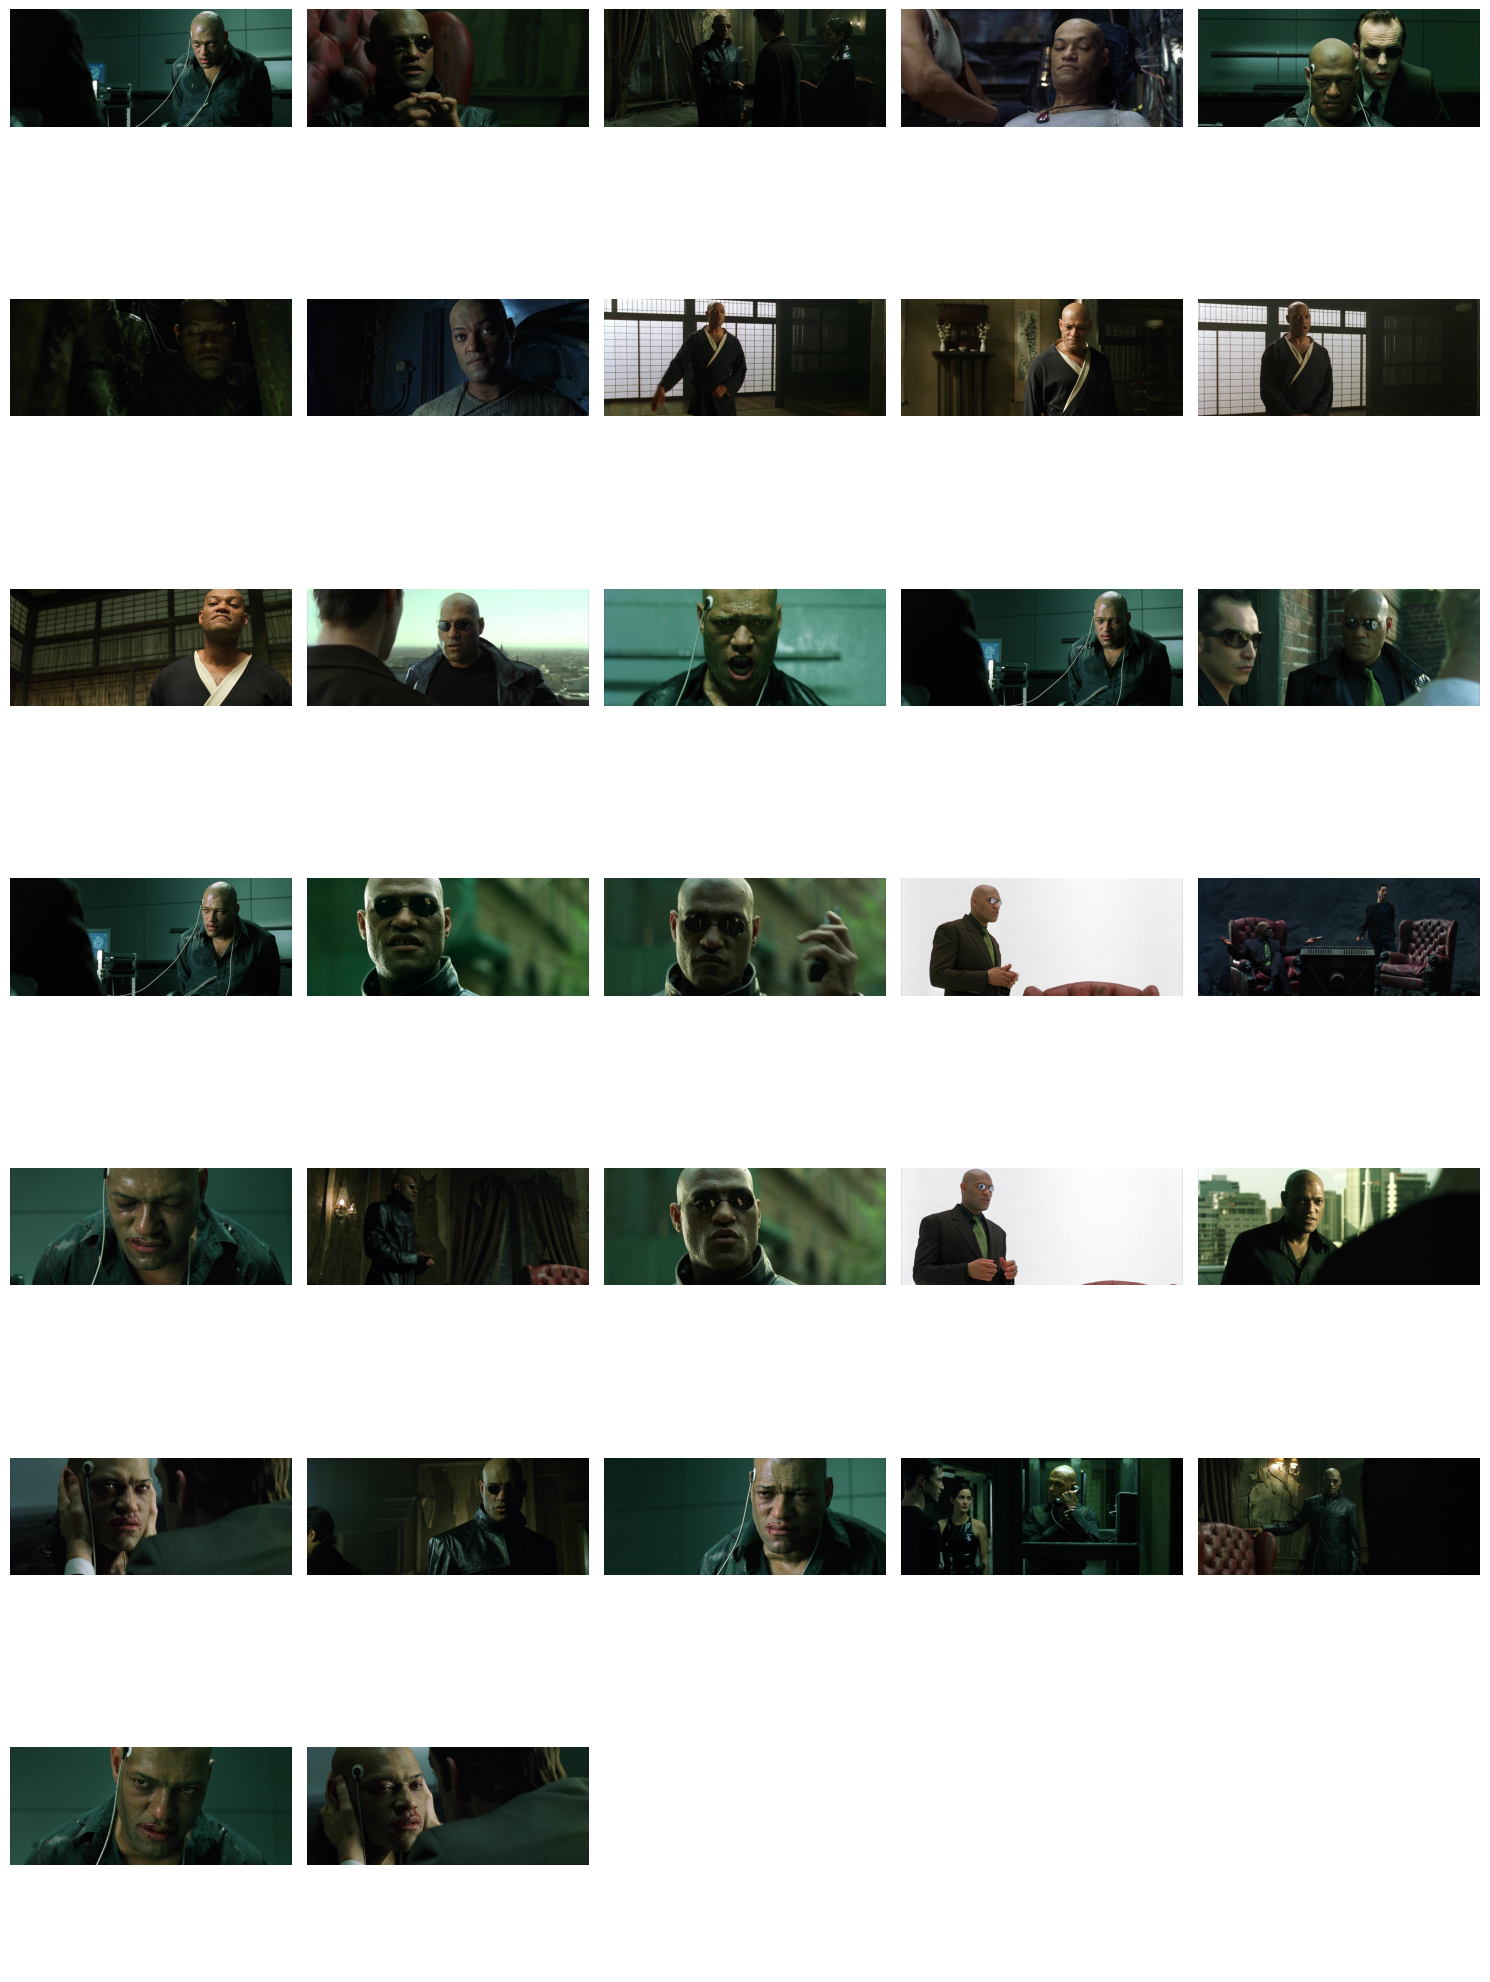

In [32]:
# plot a cluster sample
import random, math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_cluster_images(cluster, face_metadata, images_per_row=5, max_images=60):
    if len(cluster) > max_images:
        cluster = random.sample(cluster, max_images)

    num_images = len(cluster)
    num_rows = math.ceil(num_images / images_per_row)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for ax, idx in zip(axes, cluster):
        img_path = face_metadata[idx]['image_path']
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')

    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


display_cluster_images(clusters[4], metadata)

In [44]:
import torch
from PIL import Image
from transformers import AutoModel, AutoFeatureExtractor

internvit_model_id = "OpenGVLab/InternViT-300M-448px"
device = "cuda"

internvit_model = AutoModel.from_pretrained(internvit_model_id, trust_remote_code=True).to(device)
internvit_extractor = AutoFeatureExtractor.from_pretrained(internvit_model_id, trust_remote_code=True)
internvit_model.eval()

def compute_body_embedding(pil_image):
    inputs = internvit_extractor(images=pil_image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = internvit_model(**inputs)
    if hasattr(outputs, "pooler_output"):
        emb = outputs.pooler_output.squeeze(0)
    else:
        emb = outputs.last_hidden_state[:, 0, :]  # e.g. CLS token
    return emb.cpu().tolist()

def detect_body_bbox_and_embedding(meta):
    im = Image.open(meta["image_path"]).convert("RGB")
    w, h = im.size
    face = meta["face_bbox"][0]
    inp = processor(images=im, text=[["a person"]], return_tensors="pt").to(device)
    with torch.no_grad():
        out = g_model(**inp)
    r = processor.post_process_grounded_object_detection(out, inp.input_ids, 0.4, 0.3, [(h, w)])[0]
    def overlap(a, b):
        xA, yA = max(a[0], b[0]), max(a[1], b[1])
        xB, yB = min(a[2], b[2]), min(a[3], b[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        A1 = (a[2]-a[0])*(a[3]-a[1]); A2 = (b[2]-b[0])*(b[3]-b[1])
        return inter/(A1+A2-inter) if A1+A2-inter else 0
    best, best_o = None, 0
    for box, sc, lab in zip(r["boxes"], r["scores"], r["labels"]):
        box = box.tolist()
        o = overlap(face, box)
        if o > best_o:
            best_o = o
            best = box
    if not best:
        meta["body_bbox"] = None
        meta["body_embedding"] = None
        return meta
    bx1, by1, bx2, by2 = map(int, best)
    cropped_body = im.crop((bx1, by1, bx2, by2))
    meta["body_bbox"] = best
    meta["body_embedding"] = compute_body_embedding(cropped_body)
    return meta


sample_meta = metadata[clusters[4][9]]
updated_meta = detect_body_bbox_and_embedding(sample_meta)
print(updated_meta)

AssertionError: 

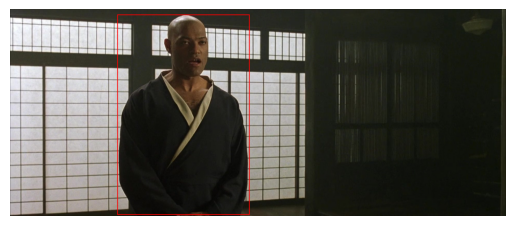

In [38]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def draw_bbox_on_image(image_path, box):
    im = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(im)
    x1, y1, x2, y2 = map(int, box)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
    plt.imshow(im)
    plt.axis("off")
    plt.show()


draw_bbox_on_image(updated_meta['image_path'], updated_meta['body_bbox'])

In [ ]:
!huggingface-cli download black-forest-labs/FLUX.1-dev
!huggingface-cli download OpenGVLab/InternViT-300M-448px
!huggingface-cli download IDEA-Research/grounding-dino-tiny
# !huggingface-cli download OpenGVLab/InternVL2-26B # for dataset creation

In [ ]:
#!/usr/bin/env python
# coding: utf-8

"""
Example: Training FLUX.1-dev for text-to-image generation with identity preservation.
All base FLUX weights are frozen; only new face/body modules are trainable.

After training, we also show how to do a "normal" text-to-image generation with FluxPipeline.
"""

import os, requests, cv2, torch
import insightface
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Instead of DiffusionPipeline, we directly import FluxPipeline
from diffusers import FluxPipeline

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import AutoModel, AutoFeatureExtractor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =====================================================================
# 1) LOAD & FREEZE THE FLUX.1-DEV PIPELINE
# =====================================================================
print("Loading and freezing FLUX.1-dev ...")
pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    device_map="balanced",          # as per your example usage
    torch_dtype=torch.bfloat16 if device.type == 'cuda' else torch.float32
)

# Freeze submodules if they exist
if hasattr(pipe, "transformer") and pipe.transformer is not None:
    for param in pipe.transformer.parameters():
        param.requires_grad = False

if hasattr(pipe, "text_encoder") and pipe.text_encoder is not None:
    for param in pipe.text_encoder.parameters():
        param.requires_grad = False

if hasattr(pipe, "text_encoder_2") and pipe.text_encoder_2 is not None:
    for param in pipe.text_encoder_2.parameters():
        param.requires_grad = False

if hasattr(pipe, "vae") and pipe.vae is not None:
    for param in pipe.vae.parameters():
        param.requires_grad = False


# =====================================================================
# 2) GROUNDING DINO FOR BODY BOUNDING BOX
# =====================================================================
print("Loading GroundingDINO ...")
g_model_id = "IDEA-Research/grounding-dino-tiny"
g_processor = AutoProcessor.from_pretrained(g_model_id)
g_model = AutoModelForZeroShotObjectDetection.from_pretrained(g_model_id).to(device)

def detect_body_bbox_pil(pil_image, query_text="a person.", threshold=0.4, text_threshold=0.3):
    """
    Given a PIL image, uses GroundingDINO to detect bounding boxes
    for the given query (default: "a person.").
    Returns the bounding box (xmin, ymin, xmax, ymax) of the largest box found,
    or None if no detection.
    """
    inputs = g_processor(images=pil_image, text=query_text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = g_model(**inputs)

    results = g_processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=threshold,
        text_threshold=text_threshold,
        target_sizes=[pil_image.size[::-1]]  # (height, width)
    )
    if not results or len(results[0]["boxes"]) == 0:
        return None

    boxes = results[0]["boxes"]  # (N, 4)
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    max_idx = torch.argmax(areas)
    box = boxes[max_idx].tolist()  # [xmin, ymin, xmax, ymax]
    return tuple(map(int, box))


# =====================================================================
# 3) INTERNVIT FOR BODY EMBEDDINGS
# =====================================================================
print("Loading InternViT-300M-448px ...")
internvit_model = AutoModel.from_pretrained("OpenGVLab/InternViT-300M-448px", trust_remote_code=True).to(device)
internvit_extractor = AutoFeatureExtractor.from_pretrained("OpenGVLab/InternViT-300M-448px", trust_remote_code=True)
internvit_model.eval()
for p in internvit_model.parameters():
    p.requires_grad = False

def extract_body_embedding_pil(pil_image, bbox=None):
    """
    Crops the bounding box region from a PIL image and extracts a body embedding.
    If bbox is None, use the entire image.
    """
    if bbox is not None:
        xmin, ymin, xmax, ymax = bbox
        pil_crop = pil_image.crop((xmin, ymin, xmax, ymax))
    else:
        pil_crop = pil_image

    inputs = internvit_extractor(images=pil_crop, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = internvit_model(**inputs)
    if hasattr(outputs, "pooler_output"):
        emb = outputs.pooler_output  # (1, hidden_dim)
    else:
        emb = outputs.last_hidden_state[:, 0, :]
    return emb  # (1, hidden_dim)


# =====================================================================
# 4) INSIGHTFACE FOR FACE EMBEDDINGS
# =====================================================================
print("Initializing InsightFace ...")
face_analysis = insightface.app.FaceAnalysis()
ctx_id = 0 if device.type == 'cuda' else -1
face_analysis.prepare(ctx_id=ctx_id, det_size=(640, 640))

def extract_face_embedding_pil(pil_image):
    """
    Convert PIL to BGR numpy, pass to insightface, return 512-dim face embedding.
    If no face is found, returns zeros.
    """
    np_img = np.array(pil_image)[:, :, ::-1]  # RGB -> BGR
    faces = face_analysis.get(np_img)
    if len(faces) == 0:
        return torch.zeros((1, 512), device=device)
    face = faces[0]
    emb = face.normed_embedding  # (512,)
    return torch.tensor(emb, dtype=torch.float32, device=device).unsqueeze(0)


# =====================================================================
# 5) NEW MODULES: PERCEIVER + CROSS-ATTENTION
# =====================================================================
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, context):
        attn_output, _ = self.attn(x, context, context)
        x = self.norm1(x + attn_output)
        mlp_output = self.mlp(x)
        x = self.norm2(x + mlp_output)
        return x

class PerceiverResampler(nn.Module):
    def __init__(self, in_dim, out_dim, num_tokens=8):
        super().__init__()
        self.num_tokens = num_tokens
        self.proj = nn.Linear(in_dim, out_dim * num_tokens)

    def forward(self, x):
        B = x.shape[0]
        out = self.proj(x).view(B, self.num_tokens, -1)
        return out


# =====================================================================
# 6) WRAPPER: Freeze FLUX, Insert New Modules
# =====================================================================
class FluxFrozenWrapper(nn.Module):
    """
    We assume everything in 'pipe' is frozen. 
    We add face/body resamplers + cross-attention blocks as trainable.
    """
    def __init__(self, pipe, embed_dim=768, num_heads=8, face_dim=512, body_dim=768):
        super().__init__()
        self.pipe = pipe  # The frozen FluxPipeline

        # Trainable modules
        self.face_resampler = PerceiverResampler(face_dim, embed_dim, num_tokens=8)
        self.body_resampler = PerceiverResampler(body_dim, embed_dim, num_tokens=8)
        self.face_cross_attn = CrossAttentionBlock(embed_dim, num_heads)
        self.body_cross_attn = CrossAttentionBlock(embed_dim, num_heads)

    def forward_unet(self, latents, t, text_embeddings, face_tokens, body_tokens):
        """
        Example approach to integrate with the frozen pipeline's UNet-like model.
        We'll assume self.pipe.unet(...) is valid in FLUX (the config suggests
        'transformer' is the underlying 2D model, but we'll keep the naming for demonstration).
        """
        unet_out = self.pipe.unet(
            latents, t, encoder_hidden_states=text_embeddings
        ).sample  # shape: (B, 4, H, W)

        B, C, H, W = unet_out.shape
        unet_out_reshaped = unet_out.view(B, C * H * W).unsqueeze(1).contiguous()

        face_attended = self.face_cross_attn(unet_out_reshaped, face_tokens)
        body_attended = self.body_cross_attn(face_attended, body_tokens)

        body_attended = body_attended.view(B, C, H, W)
        return body_attended

    def forward(self, latents, t, text_embeddings, face_emb, body_emb):
        face_tokens = self.face_resampler(face_emb)
        body_tokens = self.body_resampler(body_emb)
        out_latents = self.forward_unet(latents, t, text_embeddings, face_tokens, body_tokens)
        return out_latents


# =====================================================================
# 7) EXAMPLE DATASET
# =====================================================================
class ExampleCharacterDataset(Dataset):
    """
    Minimal example: each item has:
      - image_path: path to the reference image
      - prompt: text prompt
    We'll generate random latents and timesteps for demonstration.
    """
    def __init__(self, image_paths, prompts):
        self.image_paths = image_paths
        self.prompts = prompts

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        pil_image = Image.open(img_path).convert("RGB")
        prompt = self.prompts[idx]

        latents = torch.randn((4, 64, 64))  # mock latents
        t = torch.randint(0, 1000, (1,))
        return {
            "pil_image": pil_image,
            "prompt": prompt,
            "latents": latents,
            "timestep": t
        }


# =====================================================================
# 8) TRAINING FUNCTION
# =====================================================================
def diffusion_loss_fn(pred_latents, target_latents):
    """
    Typical MSE on latents (mock).
    In real usage, you'd have a target latents or predicted noise approach.
    """
    return F.mse_loss(pred_latents, target_latents)

def train_identity_preservation(
    flux_wrapper,
    pipe,
    dataloader,
    epochs=1,
    lr=1e-4,
    lambda_face=1.0,
    lambda_body=1.0
):
    """
    - flux_wrapper: The model with new face/body modules.
    - pipe: The original FluxPipeline (frozen).
    - dataloader: yields reference images, prompts, latents, timesteps
    """
    trainable_params = [p for p in flux_wrapper.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=lr)

    flux_wrapper.train()
    flux_wrapper.to(device)

    # Check that the submodules are frozen
    for submodel in [pipe.transformer, pipe.text_encoder, pipe.text_encoder_2, pipe.vae]:
        if submodel is not None:
            for name, p in submodel.named_parameters():
                assert not p.requires_grad, f"Parameter {name} should be frozen!"

    for epoch in range(epochs):
        for step_idx, batch in enumerate(dataloader):
            pil_image = batch["pil_image"]
            prompt = batch["prompt"]
            latents = batch["latents"].to(device, dtype=torch.float32)
            t = batch["timestep"].to(device)

            # -------------------------
            # 1) TEXT ENCODING
            # -------------------------
            if hasattr(pipe, "tokenizer") and hasattr(pipe, "text_encoder"):
                text_in = pipe.tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
                with torch.no_grad():
                    text_out = pipe.text_encoder(**text_in)
                if hasattr(text_out, "last_hidden_state"):
                    text_embeddings = text_out.last_hidden_state
                else:
                    text_embeddings = text_out
            else:
                # fallback if no built-in text encoder
                b_size = latents.shape[0]
                text_embeddings = torch.randn((b_size, 77, 768), device=device)

            # -------------------------
            # 2) FACE & BODY EMBEDDINGS
            # -------------------------
            face_emb_list = []
            body_emb_list = []
            for b in range(latents.shape[0]):
                img = pil_image[b] if isinstance(pil_image, list) else pil_image
                bbox = detect_body_bbox_pil(img, query_text="a person.")
                body_emb = extract_body_embedding_pil(img, bbox)
                body_emb_list.append(body_emb)

                face_emb = extract_face_embedding_pil(img)
                face_emb_list.append(face_emb)

            face_emb_tensor = torch.cat(face_emb_list, dim=0).to(device)
            body_emb_tensor = torch.cat(body_emb_list, dim=0).to(device)

            # -------------------------
            # 3) FORWARD PASS
            # -------------------------
            pred_latents = flux_wrapper(latents, t, text_embeddings, face_emb_tensor, body_emb_tensor)

            # Diffusion MSE (mock)
            diff_loss = diffusion_loss_fn(pred_latents, latents)

            # -------------------------
            # 4) DECODE & IDENTITY LOSS
            # -------------------------
            with torch.no_grad():
                if pred_latents.dtype != pipe.vae.dtype:
                    pred_latents = pred_latents.to(pipe.vae.dtype)
                decoded = pipe.vae.decode(pred_latents).sample  # (B, 3, H, W)

            face_loss_val = 0.0
            body_loss_val = 0.0
            b_sz = decoded.shape[0]

            for b in range(b_sz):
                # (3, H, W) -> PIL
                img_np = decoded[b].detach().cpu().float().numpy()
                img_min, img_max = img_np.min(), img_np.max()
                img_np = (img_np - img_min) / (img_max - img_min + 1e-8)
                img_np = (img_np * 255).astype(np.uint8)
                img_np = np.transpose(img_np, (1, 2, 0))
                pil_decoded = Image.fromarray(img_np)

                gen_face_emb = extract_face_embedding_pil(pil_decoded)
                f_loss = F.mse_loss(gen_face_emb, face_emb_tensor[b:b+1])
                face_loss_val += f_loss.item()

                dec_bbox = detect_body_bbox_pil(pil_decoded, query_text="a person.")
                gen_body_emb = extract_body_embedding_pil(pil_decoded, dec_bbox)
                b_loss = F.mse_loss(gen_body_emb, body_emb_tensor[b:b+1])
                body_loss_val += b_loss.item()

            face_loss_val /= b_sz
            body_loss_val /= b_sz

            face_loss = torch.tensor(face_loss_val, device=device, requires_grad=True)
            body_loss = torch.tensor(body_loss_val, device=device, requires_grad=True)

            total_loss = diff_loss + lambda_face * face_loss + lambda_body * body_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if step_idx % 5 == 0:
                print(f"Epoch {epoch} | Step {step_idx} | "
                      f"Diff={diff_loss.item():.4f} | Face={face_loss_val:.4f} | Body={body_loss_val:.4f} | "
                      f"Total={total_loss.item():.4f}")


# =====================================================================
# 9) MAIN / DEMO
# =====================================================================
def main():
    # Example dataset
    image_paths = ["./example1.jpg", "./example2.jpg"]
    prompts = ["Character in a futuristic city", "Character on the beach"]
    dataset = ExampleCharacterDataset(image_paths, prompts)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Wrap the pipeline with new modules
    flux_wrapper = FluxFrozenWrapper(
        pipe,
        embed_dim=768,
        num_heads=8,
        face_dim=512,
        body_dim=768
    ).to(device)

    # Confirm submodules are frozen
    for submodel in [pipe.transformer, pipe.text_encoder, pipe.text_encoder_2, pipe.vae]:
        if submodel is not None:
            for n, p in submodel.named_parameters():
                assert not p.requires_grad, f"Param {n} should be frozen!"

    # The only trainable parameters are in flux_wrapper
    for n, p in flux_wrapper.named_parameters():
        print(f"{n} | requires_grad={p.requires_grad}")

    # 1) Run a quick training loop
    train_identity_preservation(
        flux_wrapper,
        pipe,
        dataloader,
        epochs=1,
        lr=1e-4,
        lambda_face=1.0,
        lambda_body=1.0
    )

    # 2) Demonstrate normal usage of the pipeline for generation
    #    (You can do this after training, or skip if not needed)
    print("\nGenerating an image with the pipeline after training:")
    img = pipe(
        prompt="woman",
        guidance_scale=2,
        height=1024,
        width=1024,
        num_inference_steps=40,
        generator=torch.Generator("cuda").manual_seed(10)
    ).images[0]

    img.show()
    img.save('after_training_generation.webp')
    print("Saved 'after_training_generation.webp'")

if __name__ == "__main__":
    main()
